/scratch/tmp/19161051/ipykernel_186820/802569581.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


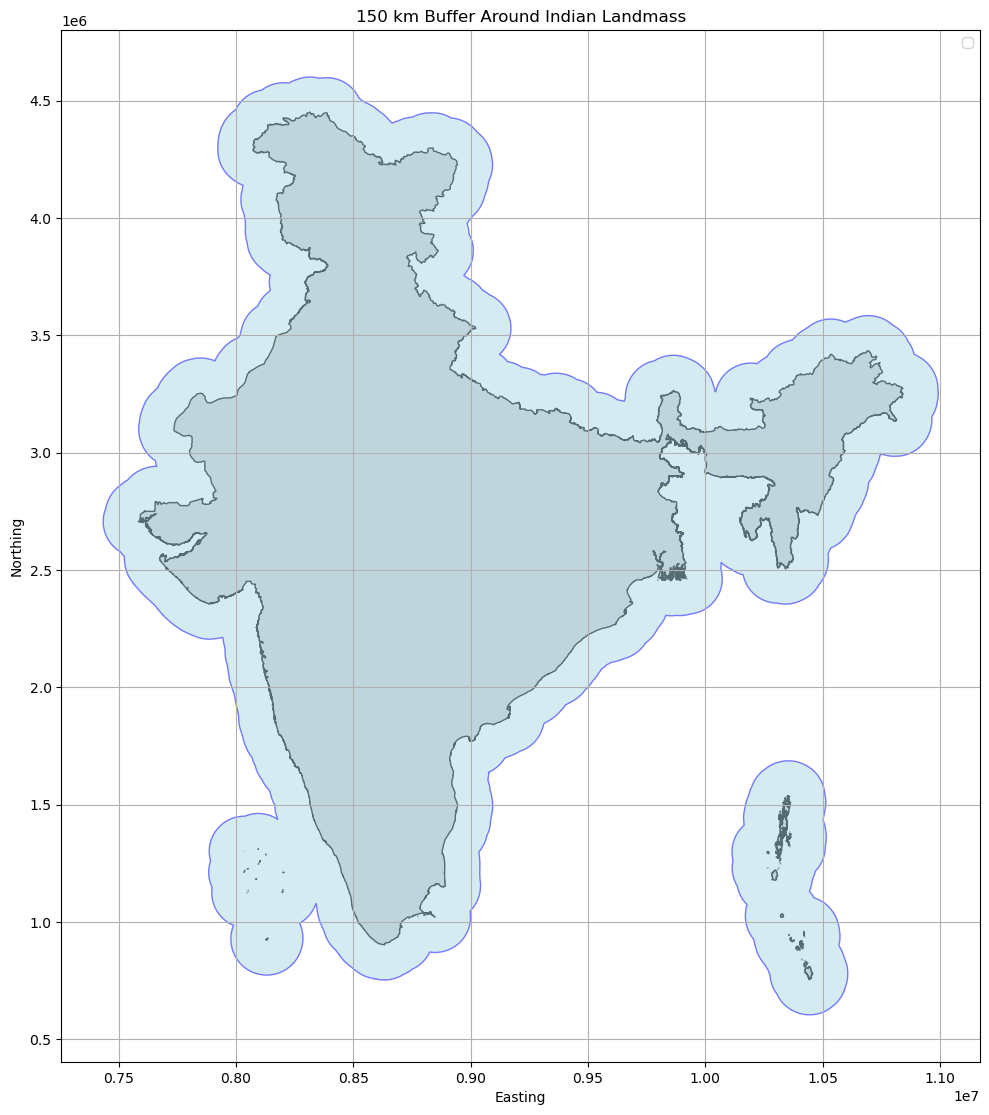

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline


# Load the India boundary shapefile
gdf = gpd.read_file("/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/India_Country_Boundary.shp")

# Dissolve all shapes into one (India as a single polygon)
india = gdf.dissolve()

# Create 150 km buffer outward (and inward if needed)
buffer_150km = india.buffer(150000)  # 150 km = 150,000 meters

# Convert to GeoDataFrame
buffer_gdf = gpd.GeoDataFrame(geometry=buffer_150km, crs=gdf.crs)

# Plot original + buffer
fig, ax = plt.subplots(figsize=(10, 12))
india.plot(ax=ax, color='lightgray', edgecolor='black', label="India Boundary")
buffer_gdf.plot(ax=ax, color='lightblue', alpha=0.5, edgecolor='blue', label="150 km Buffer")
ax.set_title("150 km Buffer Around Indian Landmass")
ax.legend()
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.grid(True)
plt.tight_layout()



In [5]:
# Save buffer as a shapefile
buffer_gdf.to_file("/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/India_150km_Buffer.shp")

/scratch/tmp/19161051/ipykernel_186820/907069467.py:22: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


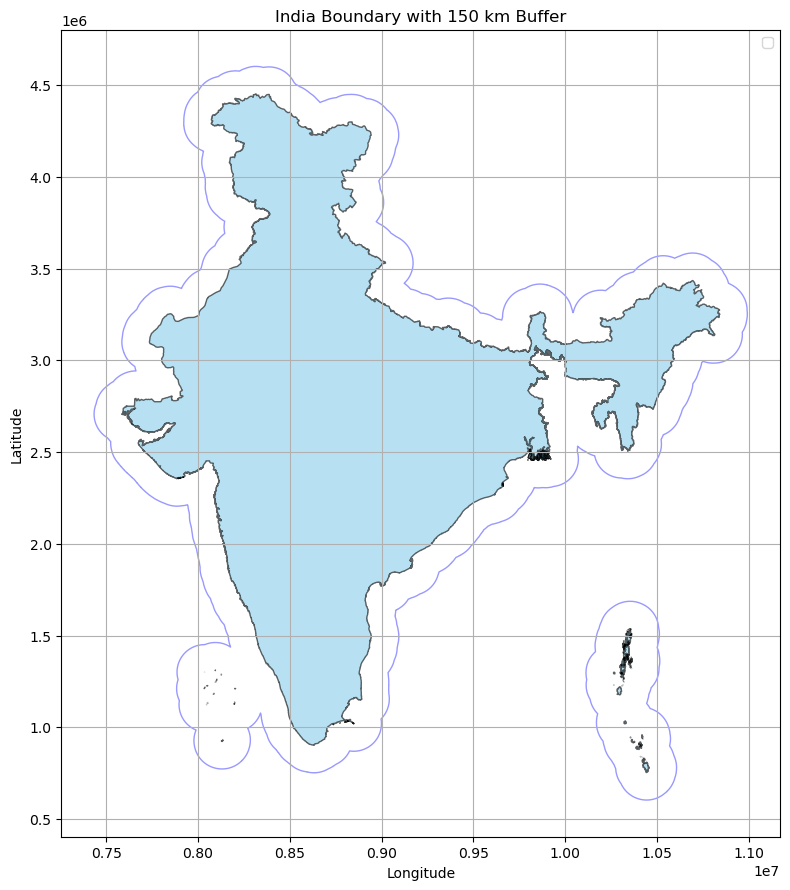

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# Read the India boundary shapefile
india_path = "/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/India_Country_Boundary.shp"
gdf_india = gpd.read_file(india_path)

# Read the 150 km buffer shapefile
buffer_path = "/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/India_150km_Buffer.shp"
gdf_buffer = gpd.read_file(buffer_path)

# Plot both
fig, ax = plt.subplots(figsize=(8, 10))
gdf_buffer.plot(ax=ax, color='none', alpha=0.4, edgecolor='blue', label='150 km Buffer')
gdf_india.plot(ax=ax, edgecolor='black', color='skyblue', alpha=0.6, label='India Boundary')

ax.set_title("India Boundary with 150 km Buffer")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


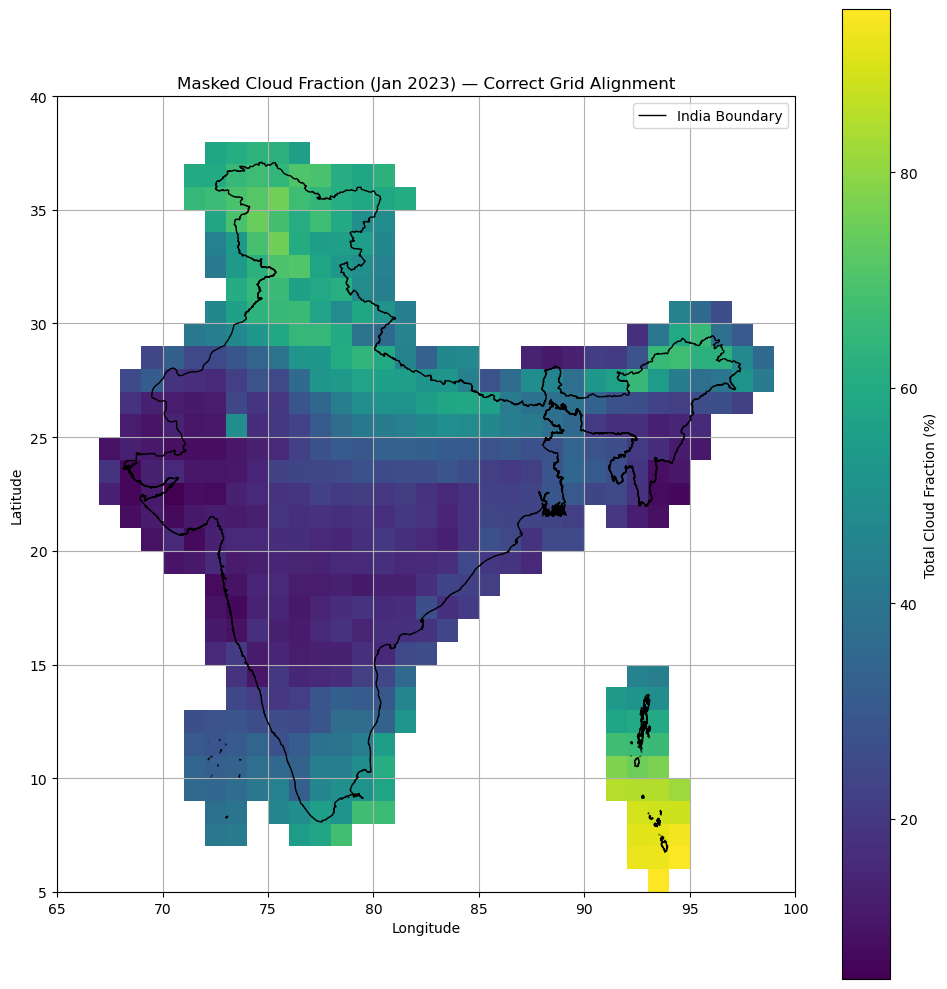

In [8]:
import xarray as xr
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio import features
from affine import Affine

# 1. Load cloud data and compute monthly mean
file_path = "/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/CERES_SYN1deg-1H_Terra-Aqua-MODIS_Ed4.1_Subset_20230101-20230131.nc"
ds = xr.open_dataset(file_path)
cld_total = ds['cldarea_total_1h'].where(ds['cldarea_total_1h'] != -999)
monthly_mean = cld_total.mean(dim='time')

lat = ds['lat'].values
lon = ds['lon'].values
lon2d, lat2d = np.meshgrid(lon, lat)

# 2. Read and reproject shapefiles to match NetCDF (WGS84)
india_shp = "/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/India_Country_Boundary.shp"
buffer_shp = "/home/bsc/bsc148104/shapefile/India-State-and-Country-Shapefile-Updated-Jan-2020/India_150km_Buffer.shp"
gdf_india = gpd.read_file(india_shp).to_crs("EPSG:4326")
gdf_buffer = gpd.read_file(buffer_shp).to_crs("EPSG:4326")

# 3. Create affine transform using lat/lon spacing
dx = lon[1] - lon[0]
dy = lat[1] - lat[0]
transform = Affine.translation(lon[0] - dx / 2, lat[0] - dy / 2) * Affine.scale(dx, dy)

# 4. Rasterize the buffer mask
mask = features.rasterize(
    [(geom, 1) for geom in gdf_buffer.geometry],
    out_shape=(len(lat), len(lon)),
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# 5. Apply the mask
masked_data = monthly_mean.where(mask == 1)

# 6. Plot everything
fig, ax = plt.subplots(figsize=(10, 10))
cf = ax.pcolormesh(lon, lat, masked_data, cmap='viridis', shading='auto')
plt.colorbar(cf, ax=ax, label='Total Cloud Fraction (%)')

#gdf_buffer.boundary.plot(ax=ax, color='none', linewidth=1, label='150 km Buffer')
gdf_india.boundary.plot(ax=ax, color='black', linewidth=1, label='India Boundary')

ax.set_title("Masked Cloud Fraction (Jan 2023) — Correct Grid Alignment")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()